<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/CompareIDRSPPValues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#read in column 7 (for signal strength) and column 12 (global IDR, which is
# used for thresholding: https://groups.google.com/forum/#!topic/idr-discuss/FY2K5VKx8AQ)
#ChIP-seq pipeline documentation including description of IDR columns is here:
# https://docs.google.com/document/d/1lG_Rd7fnYgRpSIqrIfuVlAz2dW1VaSQThzk836Db99c/edit

import gzip
import numpy as np

#download ENCSR000AKO Pooled pseudorep full IDR list (CTCF in K562)
![[ -f ENCSR000AKO_idr_PPR.gz ]] || wget "https://drive.google.com/uc?export=download&id=19xt-LnHDLfEhsP_ID9LeacFaC8c6C9bt" -O ENCSR000AKO_idr_PPR.gz

idr_peak_file = 'ENCSR000AKO_idr_PPR.gz'

signal_strength, signal_confidence = zip(*[(float(x.decode('utf-8').rstrip().split("\t")[6]),
                                            float(x.decode('utf-8').rstrip().split("\t")[11]))
                                            for x in gzip.open(idr_peak_file,'rb')])

signal_strength, signal_confidence = np.array(signal_strength), np.array(signal_confidence)


42385


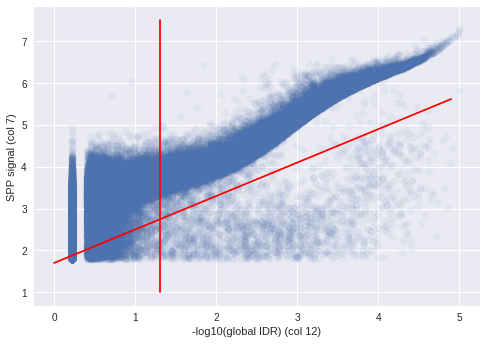

1954
40431


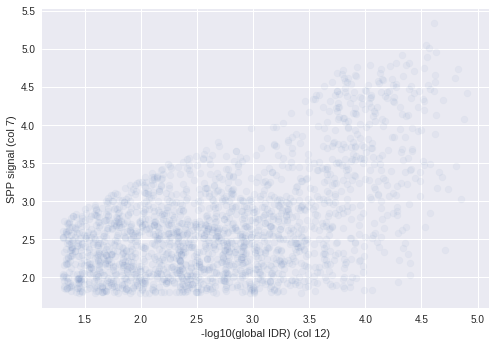

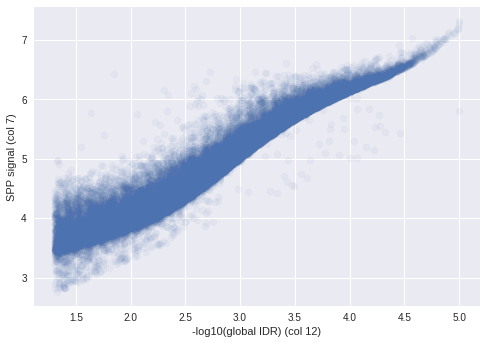

In [35]:
from matplotlib import pyplot as plt

slope=0.8
intercept=1.7
pvalthresh = -np.log(0.05)/np.log(10)

plt.scatter(signal_confidence, np.arcsinh(signal_strength), alpha=0.05)
plt.plot([pvalthresh,pvalthresh], [1,7.5], color="red")
plt.plot(np.arange(0,5,0.1),slope*np.arange(0,5,0.1)+intercept, color="red")
print(np.sum(signal_confidence > pvalthresh))
plt.xlabel("-log10(global IDR) (col 12)")
plt.ylabel("SPP signal (col 7)")
plt.show()

category1 = (signal_confidence > pvalthresh)*(np.arcsinh(signal_strength) <= (signal_confidence*slope + intercept))
category2 = (signal_confidence > pvalthresh)*(np.arcsinh(signal_strength) > (signal_confidence*slope + intercept))

print(np.sum(category1))
print(np.sum(category2))

plt.scatter(signal_confidence[category1], np.arcsinh(signal_strength)[category1], alpha=0.05)
plt.xlabel("-log10(global IDR) (col 12)")
plt.ylabel("SPP signal (col 7)")
plt.show()

plt.scatter(signal_confidence[category2], np.arcsinh(signal_strength)[category2], alpha=0.05)
plt.xlabel("-log10(global IDR) (col 12)")
plt.ylabel("SPP signal (col 7)")
plt.show()



In [47]:
!pip install pyfasta
!pip install deeptools
!pip uninstall momma_dragonn
!git clone https://github.com/kundajelab/momma_dragonn
!pip install ./momma_dragonn
!rm -rf momma_dragonn

!apt-get install bedtools
  
#Get hg38 fasta by download 2bit and then converting to fa
![[ -f hg38.2bit ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.2bit -O hg38.2bit  
![[ -f twoBitToFa ]] || wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/twoBitToFa -O twoBitToFa
!chmod a+x twoBitToFa
![[ -f hg38.genome.fa ]] || ./twoBitToFa hg38.2bit hg38.genome.fa
  
#download hg38 chromsizes file
![[ -f hg38.chrom.sizes ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes -O hg38.chrom.sizes

  Running setup.py bdist_wheel for pyfasta ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/ef/57/33/7b569168243dfbfe60bd3533e6897d170b391f2ce58df9d275
Successfully built pyfasta
    100% |████████████████████████████████| 3.3MB 9.4MB/s 
    100% |████████████████████████████████| 9.7MB 3.8MB/s 
    100% |████████████████████████████████| 71kB 22.6MB/s 
    100% |████████████████████████████████| 37.8MB 928kB/s 
    100% |████████████████████████████████| 3.1MB 10.4MB/s 
    100% |████████████████████████████████| 71kB 23.5MB/s 
    100% |████████████████████████████████| 8.1MB 4.7MB/s 
    100% |████████████████████████████████| 552kB 21.8MB/s 
  Running setup.py bdist_wheel for deeptools ... - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/26/7b/1a/e828c248cbb05db00a41118e24c0435bcdbf1b750f4dd2c0c8
  Running setup.py bdist_wheel for numpydoc ... - done
  Stored in directory: /root/.cache/pip/wheels/ea/55/7f/3e25d754760cc

In [0]:
#do an asinh transform of column 7 (SPP singal strength)
!zcat ENCSR000AKO_idr_PPR.gz | perl -lane 'BEGIN{use Math::Trig} {print $F[0]."\t".(($F[1]+$F[9]))."\t".(($F[1]+$F[9]))."\t".asinh($F[6])."\t".$F[11]}' | bedtools slop -g hg38.chrom.sizes -b 500 | perl -lane 'if ($F[2]-$F[1]==1000) {print $F[0]."\t".$F[1]."\t".$F[2]."\t1\t$F[3]\t".$F[4]}' | sortBed | gzip -c > positives_hybridbnc_asinh_spp.gz

import os
import sys
import gzip
from collections import OrderedDict

def tile_across_genome(chrom_sizes_file,
                       chroms_to_exclude,
                       out_file, bin_sizes,
                       bin_stride):

    chromosome_sizes = OrderedDict()
    for line in open(chrom_sizes_file):
        chrom, size = line.rstrip().split("\t")
        if (("_" not in chrom) and
            (chrom not in chroms_to_exclude)):
            size = int(size)
            chromosome_sizes[chrom] = size 
        else:
            pass
            #print("Dropping chrom",chrom)

    outfile = open(out_file, "w")
    
    for a_chrom in chromosome_sizes:
        the_end = chromosome_sizes[a_chrom] 
        bin_start = 0
        while ((bin_start + bin_sizes) < the_end):
            outfile.write(a_chrom+"\t"+str(bin_start)
                          +"\t"+str(bin_start+bin_sizes)+"\n")
            bin_start += bin_stride

    outfile.close()

if (os.path.isfile("1kb_tiles.bed")==False):
  print("Tiling across the genome in 1kb windows")
  tile_across_genome(out_file = "1kb_tiles.bed",
                     chrom_sizes_file="hg38.chrom.sizes",
                     bin_sizes=1000,
                     bin_stride=1000,
                     chroms_to_exclude=["chrM"])    

  
# Negative set: 1kb regions tiling across the genome that do not overlap any of the peaks in the idr file
!bedtools intersect -sorted -v -a 1kb_tiles.bed -b positives_hybridbnc_asinh_spp.gz -wa | perl -lane 'print $F[0]."\t".$F[1]."\t".$F[2]."\t0\t0\t0"' | gzip -c > negative_regions.gz
!zcat positives_hybridbnc_asinh_spp.gz negative_regions.gz | sortBed | gzip -c > hybridbnc_asinh_spp_labels.gz

#train-test-valid splits
!zcat hybridbnc_asinh_spp_labels.gz | egrep -w 'chr1|chr8|chr21' | gzip -c > test_hybridbnc_asinh_spp_labels.gz
!zcat test_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==1) {print $_}' | gzip -c > positives_test_hybridbnc_asinh_spp_labels.gz
!zcat test_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==0) {print $_}' | gzip -c > negatives_test_hybridbnc_asinh_spp_labels.gz
!zcat hybridbnc_asinh_spp_labels.gz | egrep -w 'chr22' | gzip -c > valid_hybridbnc_asinh_spp_labels.gz
!zcat valid_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==1) {print $_}' | gzip -c > positives_valid_hybridbnc_asinh_spp_labels.gz
!zcat valid_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==0) {print $_}' | gzip -c > negatives_valid_hybridbnc_asinh_spp_labels.gz
!zcat hybridbnc_asinh_spp_labels.gz | egrep -w -v 'chr1|chr8|chr21|chr22' | gzip -c > train_hybridbnc_asinh_spp_labels.gz
!zcat train_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==1) {print $_}' | gzip -c > positives_train_hybridbnc_asinh_spp_labels.gz
!zcat train_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==0) {print $_}' | gzip -c > negatives_train_hybridbnc_asinh_spp_labels.gz


In [0]:
from keras.models import load_model
from keras.models import Model

from collections import OrderedDict
import numpy as np

import keras
from keras.models import Model
from momma_dragonn.data_loaders import pyfasta_data_loader
import six

def get_single_stream_data_generator(**kwargs):

  return pyfasta_data_loader.SingleStreamSeqOnly(
               fasta_data_source="hg38.genome.fa",
               rc_augment=True,
               num_to_load_for_eval=100, #not used
               labels_dtype="float",
               wrap_in_keys=["sequence", "output"],
               randomize_after_pass=True,
               **kwargs)

def iterate_over_generator_in_batches(batch_size, generator):
  X_batch = []
  y_batch = []
  for (X_ex, y_ex, coor, fastastr) in generator:
    X_batch.append(X_ex)
    y_batch.append(y_ex)
    if (len(X_batch)==batch_size):
      yield np.array(X_batch), np.array(y_batch)
      X_batch = []
      y_batch = []
  if (len(X_batch) > 0):
    yield np.array(X_batch), np.array(y_batch)
    
def get_predictions_and_true_labels(bed_source, labels_subset, name_to_model): 
  generator = pyfasta_data_loader.SingleStreamSeqOnly(
     batch_size=None,
     bed_source=bed_source,
     labels_subset=labels_subset,
     fasta_data_source="hg38.genome.fa",
     rc_augment=True,
     num_to_load_for_eval=None, #not used
     labels_dtype="float",
     wrap_in_keys=["sequence", "output"],
     randomize_after_pass=False).get_generator(loop_infinitely=False)  
  name_to_predictions = OrderedDict()
  true_y = []
  for X_batch, y_batch in iterate_over_generator_in_batches(
                            batch_size=200, generator=generator):
    true_y.extend(y_batch)
    for name in name_to_model:
      if name not in name_to_predictions:
        name_to_predictions[name] = []
      name_to_predictions[name].extend(name_to_model[name].predict(
                                       {'sequence': X_batch}))
  for name in name_to_predictions:
    name_to_predictions[name] = np.array(name_to_predictions[name])
  return np.array(true_y), name_to_predictions

#load pretrained binary model
![[ -f binary_model_2018Nov28_0136pm.h5 ]] || wget "https://drive.google.com/uc?export=download&id=1-3p_mB6QBGxnYdnpiQx1etfKZM8i8Xxk" -O binary_model_2018Nov28_0136pm.h5
#load pretrained regression model
![[ -f positives_asinh_spp_model_2018Nov28_0908am_chromosomeholdout.h5 ]] || wget "https://drive.google.com/uc?export=download&id=13pYwgbmv8F5aHQvWkcaj-XtXnCRqnRN5" -O positives_asinh_spp_model_2018Nov28_0908am_chromosomeholdout.h5


binary_model = load_model("binary_model_2018Nov28_0136pm.h5")
binary_preact_model = Model(inputs=binary_model.layers[0].input,
                            outputs=binary_model.layers[-2].output)
positives_asinh_spp_model = load_model("positives_asinh_spp_model_2018Nov28_0908am_chromosomeholdout.h5")

positives_asinh_spp_name_to_model = {'positives_asinh_spp_model': positives_asinh_spp_model,
                                     'binary_preact_model': binary_preact_model}

#verify no train-test contamination!
!bedtools intersect -sorted -a positives_test_hybridbnc_asinh_spp_labels.gz -b positives_train_hybridbnc_asinh_spp_labels.gz | wc -l
!bedtools intersect -sorted -a positives_test_hybridbnc_asinh_spp_labels.gz -b positives_valid_hybridbnc_asinh_spp_labels.gz | wc -l


test_positives_asinh_spp_y, test_positives_asinh_spp_name_to_predictions = get_predictions_and_true_labels(
    bed_source="positives_test_hybridbnc_asinh_spp_labels.gz",
    labels_subset=[1,2],
    name_to_model=positives_asinh_spp_name_to_model)
#train_positives_asinh_spp_y, train_positives_asinh_spp_name_to_predictions = get_predictions_and_true_labels(
#    bed_source="positives_train_hybridbnc_asinh_spp_labels.gz",
#    labels_subset=[1,2],
#    name_to_model=positives_asinh_spp_name_to_model)
#valid_positives_asinh_spp_y, valid_positives_asinh_spp_name_to_predictions = get_predictions_and_true_labels(
#    bed_source="positives_valid_hybridbnc_asinh_spp_labels.gz",
#    labels_subset=[1,2],
#    name_to_model=positives_asinh_spp_name_to_model)

0
0
Reading bed file positives_test_hybridbnc_asinh_spp_labels.gz into memory
Finished reading bed file into memory; got 17609rows


In [0]:
#Start with simple 3-class classification;
#'ambiguous' for every peaks with -log10(global IDR) < 2
#class 0 is for negatives
#class 1 is 